In [1]:
import scanpy as sc
import pandas as pd
import celltypist
import json
import matplotlib.pyplot as plt
from celltypist import models

RANDOM_STATE = 42
RESULTS_FOLDER = 'results/'
DATA_PATH = 'data/GSE239626/MTX'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Import data

In [2]:
adata = sc.read_10x_mtx(
    DATA_PATH,
    var_names='gene_symbols',
    gex_only=False,
    cache=True)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 72317 × 36636
    var: 'gene_ids', 'feature_types'

In [3]:
adata = adata[:, adata.var['feature_types'] == 'Gene Expression']

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
adata.X

<72317x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 96626578 stored elements in Compressed Sparse Column format>

In [6]:
labels = pd.read_csv(RESULTS_FOLDER+'cluster_labels.csv')
adata.obs['leiden'] = labels['leiden']
adata

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'leiden'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

### Model

In [7]:
models.download_models(force_update=False)

📂 Storing models in C:\Users\giuli\.celltypist\data\models
⏩ Skipping [1/46]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/46]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/46]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [4/46]: Adult_Human_PancreaticIslet.pkl (file exists)


⏩ Skipping [5/46]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [6/46]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [7/46]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [8/46]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [9/46]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [10/46]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [11/46]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [12/46]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [13/46]: Cells_Adult_Breast.pkl (file exists)
⏩ Skipping [14/46]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [15/46]: Cells_Human_Tonsil.pkl (file exists)
⏩ Skipping [16/46]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [17/46]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [18/46]: Developing_Human_Brain.pkl (file exists)
⏩ Skipping [19/46]: Developing_Human_Gonads.pkl (file exists)
⏩ Skipping [20/46]: Developing_Human_Hippocampus.pkl (file exists)
⏩ Skipping [21/46]: Developing_Human_

In [8]:
model_name = 'Immune_All_High'

In [9]:
model = models.Model.load(model = model_name+'.pkl') # 'Immune_All_High'

In [10]:
display(model)
#display(model.cell_types)

CellTypist model with 32 cell types and 6639 features
    date: 2022-07-16 08:53:00.959521
    details: immune populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: B cells, B-cell lineage, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

Detect neighborhood graph

In [11]:
clustering_labels_df = pd.read_csv(RESULTS_FOLDER+'cluster_labels.csv', index_col=0)
clustering_labels = clustering_labels_df['leiden'].values

In [12]:
clustering_score_df = pd.read_csv(RESULTS_FOLDER+'clustering_score.csv')

row = clustering_score_df[clustering_score_df['silhouette_score'] == clustering_score_df['silhouette_score'].max()]
n_neighbors = row['n_neighbors'].values[0]
resolution = row['resolution'].values[0]
pca_dim = row['pca_dim'].values[0]

sc.pp.neighbors(
    adata,
    n_neighbors=n_neighbors,
    n_pcs=pca_dim,
    knn=True,
    metric='euclidean', # 'correlation'
    random_state=RANDOM_STATE
    )

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [13]:
adata.uns['neighbors']

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'n_neighbors': 10,
  'method': 'umap',
  'random_state': 42,
  'metric': 'euclidean',
  'n_pcs': 5}}

Make predictions, finally :)

In [14]:
predictions = celltypist.annotate(
    adata,
    model = model_name+'.pkl',
    majority_voting=True,
    mode='best match'
)

🔬 Input data has 72317 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [15]:
predictions

CellTypist prediction result for 72317 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 72317 query cells and 32 cell types
    probability_matrix: data frame with 72317 query cells and 32 cell types
    adata: AnnData object referred

Save model

In [16]:
model.write(RESULTS_FOLDER+model_name+'_GSE239626_model.pkl')

### Results

In [17]:
predictions.predicted_labels.head()

,predicted_labels,over_clustering,majority_voting
AAACCCAAGACTGTTC-1,T cells,338,T cells
AAACCCAAGGATCATA-1,T cells,28,T cells
AAACCCAGTTATTCTC-1,B cells,413,B cells
AAACCCATCATGAGGG-1,T cells,142,T cells
AAACGAAAGCCAGTAG-1,B cells,306,B cells


In [18]:
predictions.predicted_labels.to_csv(RESULTS_FOLDER+'celltypist_labels_'+model_name+'.csv')

In [19]:
len(predictions.predicted_labels['predicted_labels'].unique())

19

In [20]:
adata.obs['predicted_labels'] = predictions.predicted_labels['predicted_labels']

... storing 'feature_types' as categorical


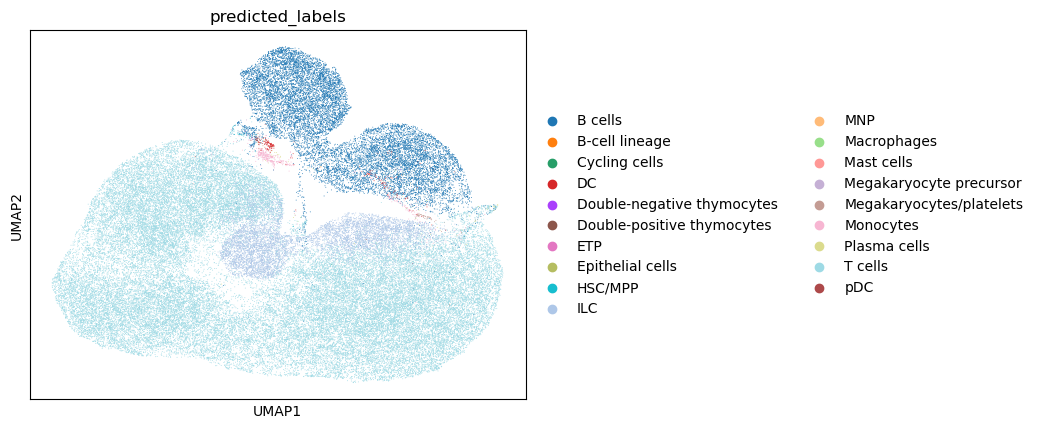

In [21]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['predicted_labels'], color_map='tab20')

In [22]:
adata.obs['predicted_labels'].value_counts()

predicted_labels
T cells                       51282
B cells                       12978
ILC                            7216
Monocytes                       417
DC                              156
Plasma cells                     76
pDC                              57
Megakaryocytes/platelets         41
HSC/MPP                          34
Megakaryocyte precursor          19
Macrophages                      14
ETP                              12
Double-positive thymocytes        6
Cycling cells                     3
Mast cells                        2
Double-negative thymocytes        1
Epithelial cells                  1
B-cell lineage                    1
MNP                               1
Name: count, dtype: int64

In [23]:
labels = adata.obs['predicted_labels'].value_counts()[adata.obs['predicted_labels'].value_counts() > 1].index
labels

CategoricalIndex(['T cells', 'B cells', 'ILC', 'Monocytes', 'DC',
                  'Plasma cells', 'pDC', 'Megakaryocytes/platelets', 'HSC/MPP',
                  'Megakaryocyte precursor', 'Macrophages', 'ETP',
                  'Double-positive thymocytes', 'Cycling cells', 'Mast cells'],
                 categories=['B cells', 'B-cell lineage', 'Cycling cells', 'DC', ..., 'Monocytes', 'Plasma cells', 'T cells', 'pDC'], ordered=False, dtype='category', name='predicted_labels')

In [24]:
adata = adata[adata.obs['predicted_labels'].isin(labels)]
sc.tl.rank_genes_groups(adata, groupby='predicted_labels', method='t-test')
gene_groups = adata.uns['rank_genes_groups']

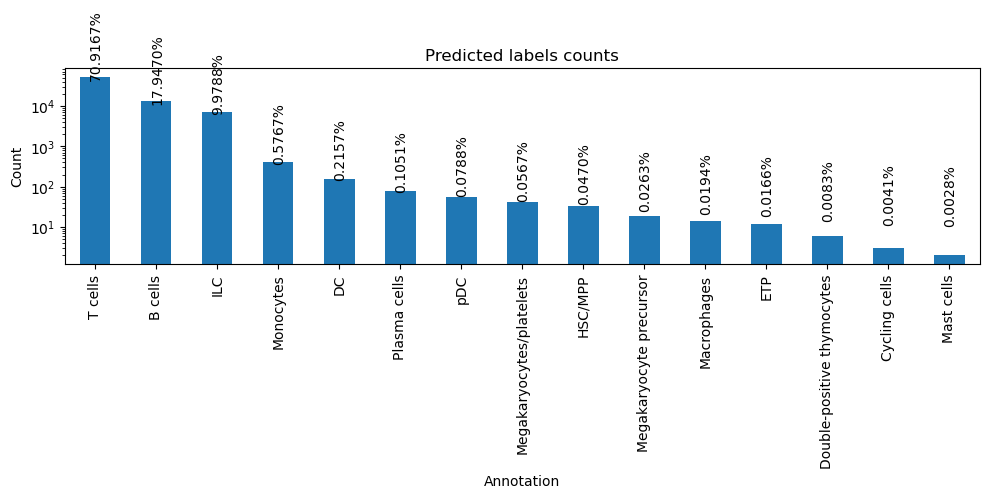

In [25]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
adata.obs['predicted_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata.obs['predicted_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Predicted labels counts')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [26]:
adata

AnnData object with n_obs × n_vars = 72313 × 36601
    obs: 'leiden', 'predicted_labels'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'neighbors', 'over_clustering', 'umap', 'predicted_labels_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [27]:
predictions.predicted_labels['predicted_labels'].unique()

['T cells', 'B cells', 'ILC', 'Monocytes', 'Macrophages', ..., 'Mast cells', 'B-cell lineage', 'Double-negative thymocytes', 'MNP', 'Epithelial cells']
Length: 19
Categories (19, object): ['B cells', 'B-cell lineage', 'Cycling cells', 'DC', ..., 'Monocytes', 'Plasma cells', 'T cells', 'pDC']

In [28]:
markers = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers[label] = gene_groups['names'][label].tolist()[:10] # top 10 markers, for each cell type

print(markers)

{'T cells': ['IL7R', 'BCL11B', 'TRAC', 'CD3D', 'CD3G', 'CD3E', 'FYB1', 'IL32', 'TCF7', 'PRKCQ-AS1'], 'B cells': ['MS4A1', 'CD74', 'HLA-DRA', 'IGHM', 'HLA-DQB1', 'BANK1', 'HLA-DRB1', 'RALGPS2', 'LINC00926', 'CD79A'], 'ILC': ['GNLY', 'PRF1', 'KLRD1', 'NKG7', 'GZMB', 'KLRF1', 'CD247', 'SPON2', 'CTSW', 'EFHD2'], 'Monocytes': ['NEAT1', 'PSAP', 'TYMP', 'IFI30', 'COTL1', 'ZEB2', 'CTSS', 'LST1', 'SAT1', 'FCN1'], 'Macrophages': ['GRN', 'TNFAIP2', 'TYMP', 'CSF3R', 'CCDC88A', 'MS4A7', 'MT-ND4L', 'LYZ', 'TYROBP', 'CTBP2'], 'Plasma cells': ['TXNDC5', 'MZB1', 'JCHAIN', 'ITM2C', 'IGHA1', 'IGKC', 'HSP90B1', 'UBE2J1', 'TNFRSF17', 'DERL3'], 'HSC/MPP': ['ZFAS1', 'SOX4', 'RPL3', 'HNRNPA1', 'EEF1G', 'RPS9', 'RACK1', 'RPS23', 'HINT1', 'RPL22'], 'Megakaryocytes/platelets': ['GP1BB', 'NRGN', 'CAVIN2', 'PPBP', 'GNG11', 'TUBB1', 'FTH1', 'CCL5', 'CLU', 'TLN1'], 'DC': ['HLA-DQB1', 'HLA-DRB1', 'CD74', 'HLA-DRA', 'HLA-DPB1', 'HLA-DMB', 'CST3', 'LYZ', 'GRN', 'HLA-DRB5'], 'pDC': ['TCF4', 'IRF8', 'UGCG', 'CD74', 'BCL1

In [29]:
with open(RESULTS_FOLDER+'celltypist_markers_'+model_name+'.json', 'w') as f:
    json.dump(markers, f)

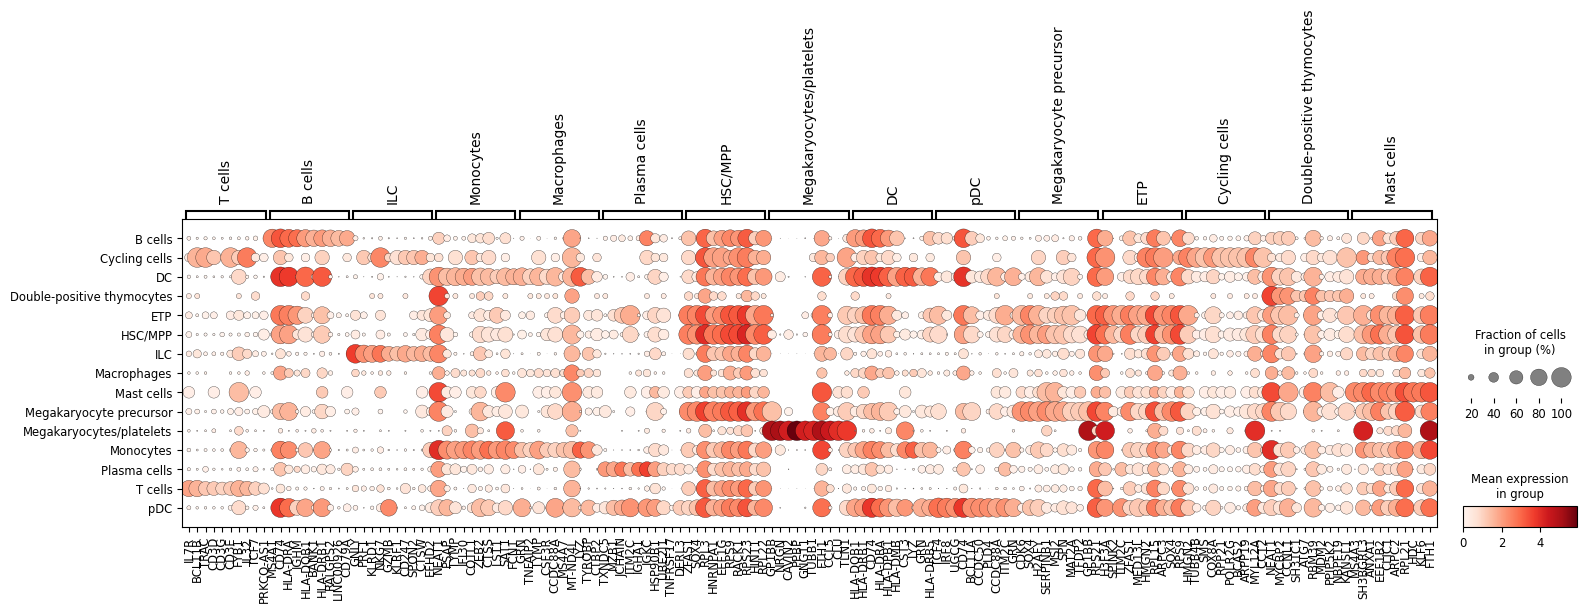

In [30]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="predicted_labels",
    figsize=(18, 4),
)